<a href="https://colab.research.google.com/github/RamonSaturninoM/NLP-Transfer-Learning-and-Prompt-Engineering/blob/master/Transfer_learning_%26_PE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#------------
# Question 1: Transfer Learning
#------------

def load_conll_data(filepath):
    tokens = []
    tags = []
    sentence = []
    ner = []

    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:  # End of sentence
                if sentence:
                    tokens.append(sentence)
                    tags.append(ner)
                    sentence = []
                    ner = []
            else:
                splits = line.split()
                sentence.append(splits[0])
                ner.append(splits[-1])

    return {"tokens": tokens, "ner_tags": tags}


In [ ]:
train_data = load_conll_data("btc_conll/btc.train")
val_data = load_conll_data("btc_conll/btc.dev")
test_data = load_conll_data("btc_conll/btc.test")


In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)


In [ ]:
# Get all unique tags
unique_tags = set(tag for seq in train_data['ner_tags'] for tag in seq)
unique_tags = sorted(list(unique_tags))  # Consistent order

# Map tags to IDs and vice versa
tag2id = {tag: idx for idx, tag in enumerate(unique_tags)}
id2tag = {idx: tag for tag, idx in tag2id.items()}


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], is_split_into_words=True, truncation=True)

    labels = []
    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)  # Ignored in loss
        elif word_idx != previous_word_idx:
            labels.append(tag2id[example["ner_tags"][word_idx]])
        else:
            labels.append(-100)  # Only label first subword
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


In [ ]:
train_dataset = train_dataset.map(tokenize_and_align_labels)
val_dataset = val_dataset.map(tokenize_and_align_labels)
test_dataset = test_dataset.map(tokenize_and_align_labels)


Map:   0%|          | 0/6338 [00:00<?, ? examples/s]

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2id),
    id2label=id2tag,
    label2id=tag2id
)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
from evaluate import load

metric = load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2tag[p] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag[l] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "accuracy": results["overall_accuracy"],
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"]
    }


In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorForTokenClassification

args = TrainingArguments(
    output_dir="bert-ner-btc",
    #evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01
)

data_collator = DataCollatorForTokenClassification(tokenizer)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


<ipython-input-10-e7e0bc028734>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["TRANSFORMERS_NO_WANDB"] = "1"

trainer.train()

Step,Training Loss
397,0.215200
794,0.100900
1191,0.068800
1588,0.048600
1985,0.036400


TrainOutput(global_step=1985, training_loss=0.09398649825857629, metrics={'train_runtime': 414.3634, 'train_samples_per_second': 76.479, 'train_steps_per_second': 4.79, 'total_flos': 913258136124180.0, 'train_loss': 0.09398649825857629, 'epoch': 5.0})

In [ ]:
trainer.evaluate(test_dataset)


{'eval_loss': 0.16485297679901123,
 'eval_accuracy': 0.9565585570327716,
 'eval_precision': 0.8088888888888889,
 'eval_recall': 0.7486288848263254,
 'eval_f1': 0.7775931640161404,
 'eval_runtime': 7.6973,
 'eval_samples_per_second': 259.96,
 'eval_steps_per_second': 16.369,
 'epoch': 5.0}

In [ ]:
predictions_output = trainer.predict(test_dataset)
logits = predictions_output.predictions
labels = predictions_output.label_ids

import numpy as np
pred_tags = np.argmax(logits, axis=2)

true_labels = []
pred_labels = []

for pred, label in zip(pred_tags, labels):
    for p, l in zip(pred, label):
        if l != -100:
            true_labels.append(id2tag[l])
            pred_labels.append(id2tag[p])


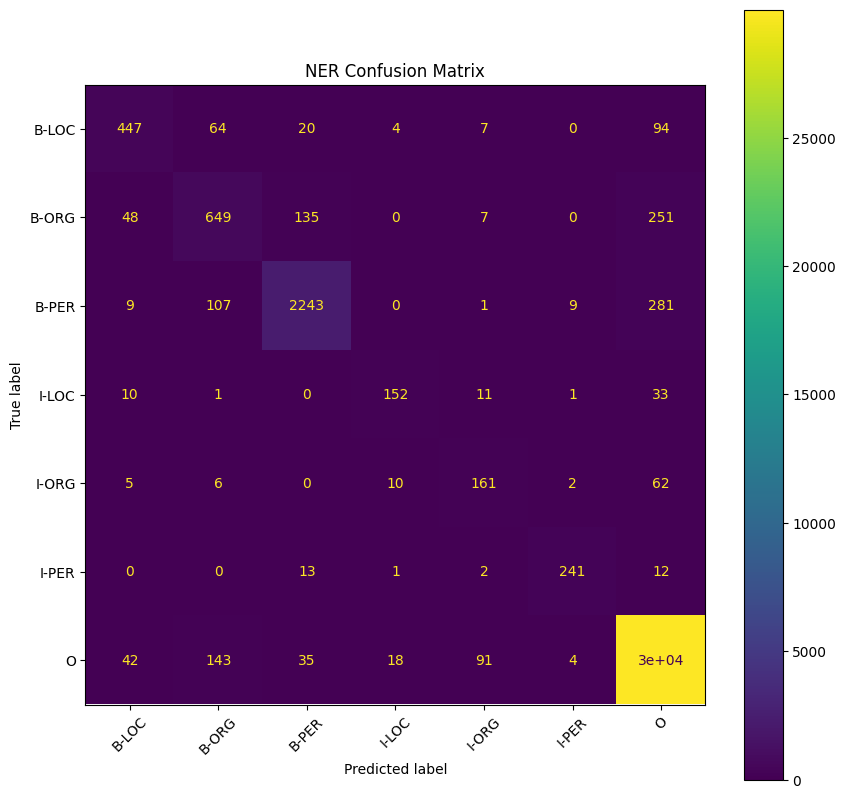

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels_list = list(tag2id.keys())

cm = confusion_matrix(true_labels, pred_labels, labels=labels_list)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_list)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("NER Confusion Matrix")
plt.show()
